# 🔧 环境配置和检查

## 概述
本教程需要特定的环境配置以确保最佳学习体验。以下配置将帮助您：
- 使用统一的conda环境
- 通过国内镜像源快速安装依赖
- 加速模型下载
- 检查系统配置

## 配置步骤
1. **Conda环境管理** - 激活统一的学习环境
2. **包管理器优化** - 配置pip使用清华镜像源
3. **模型下载加速** - 设置HuggingFace镜像代理
4. **系统环境诊断** - 检查硬件和软件配置


In [ ]:
# 1. 激活conda环境
%%script bash
# 初始化 conda
eval "$(conda shell.bash hook)"
conda activate flyai_agent_in_action
conda env list


In [ ]:
# 2. 设置pip 为清华源
%pip config set global.index-url https://pypi.tuna.tsinghua.edu.cn/simple
%pip config list


In [ ]:
# 3. 设置HuggingFace代理
%env HF_ENDPOINT=https://hf-mirror.com
# 验证：使用shell命令检查
!echo $HF_ENDPOINT

In [ ]:
# 🔍 环境信息检查脚本
#
# 本脚本的作用：
# 1. 安装 pandas 库用于数据表格展示
# 2. 检查系统的各项配置信息
# 3. 生成详细的环境报告表格
#
# 对于初学者来说，这个步骤帮助您：
# - 了解当前运行环境的硬件配置
# - 确认是否满足模型运行的最低要求
# - 学习如何通过代码获取系统信息

# 安装 pandas 库 - 用于创建和展示数据表格
# pandas 是 Python 中最流行的数据处理和分析库
%pip install pandas==2.2.2 tabulate==0.9.0

import platform # 导入 platform 模块以获取系统信息
import os # 导入 os 模块以与操作系统交互
import subprocess # 导入 subprocess 模块以运行外部命令
import pandas as pd # 导入 pandas 模块，通常用于数据处理，这里用于创建表格
import shutil # 导入 shutil 模块以获取磁盘空间信息

# 获取 CPU 信息的函数，包括核心数量
def get_cpu_info():
    cpu_info = "" # 初始化 CPU 信息字符串
    physical_cores = "N/A"
    logical_cores = "N/A"

    if platform.system() == "Windows": # 如果是 Windows 系统
        cpu_info = platform.processor() # 使用 platform.processor() 获取 CPU 信息
        try:
            # 获取 Windows 上的核心数量 (需要 WMI)
            import wmi
            c = wmi.WMI()
            for proc in c.Win32_Processor():
                physical_cores = proc.NumberOfCores
                logical_cores = proc.NumberOfLogicalProcessors
        except:
            pass # 如果 WMI 不可用，忽略错误

    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取 CPU 信息和核心数量
        os.environ['PATH'] = os.environ['PATH'] + os.pathsep + '/usr/sbin' # 更新 PATH 环境变量
        try:
            process_brand = subprocess.Popen(['sysctl', "machdep.cpu.brand_string"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_brand, stderr_brand = process_brand.communicate()
            cpu_info = stdout_brand.decode().split(': ')[1].strip() if stdout_brand else "Could not retrieve CPU info"

            process_physical = subprocess.Popen(['sysctl', "hw.physicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_physical, stderr_physical = process_physical.communicate()
            physical_cores = stdout_physical.decode().split(': ')[1].strip() if stdout_physical else "N/A"

            process_logical = subprocess.Popen(['sysctl', "hw.logicalcpu"], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout_logical, stderr_logical = process_logical.communicate()
            logical_cores = stdout_logical.decode().split(': ')[1].strip() if stdout_logical else "N/A"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/cpuinfo 文件获取 CPU 信息和核心数量
            with open('/proc/cpuinfo') as f:
                physical_cores_count = 0
                logical_cores_count = 0
                cpu_info_lines = []
                for line in f:
                    if line.startswith('model name'): # 查找以 'model name'开头的行
                        if not cpu_info: # 只获取第一个 model name
                            cpu_info = line.split(': ')[1].strip()
                    elif line.startswith('cpu cores'): # 查找以 'cpu cores' 开头的行
                        physical_cores_count = int(line.split(': ')[1].strip())
                    elif line.startswith('processor'): # 查找以 'processor' 开头的行
                        logical_cores_count += 1
                physical_cores = str(physical_cores_count) if physical_cores_count > 0 else "N/A"
                logical_cores = str(logical_cores_count) if logical_cores_count > 0 else "N/A"
                if not cpu_info:
                     cpu_info = "Could not retrieve CPU info"

        except:
            cpu_info = "Could not retrieve CPU info"
            physical_cores = "N/A"
            logical_cores = "N/A"

    return f"{cpu_info} ({physical_cores} physical cores, {logical_cores} logical cores)" # 返回 CPU 信息和核心数量


# 获取内存信息的函数
def get_memory_info():
    mem_info = "" # 初始化内存信息字符串
    if platform.system() == "Windows":
        # 在 Windows 上不容易通过标准库获取，需要外部库或 PowerShell
        mem_info = "Requires external tools on Windows" # 设置提示信息
    elif platform.system() == "Darwin": # 如果是 macOS 系统
        # 在 macOS 上使用 sysctl 命令获取内存大小
        process = subprocess.Popen(['sysctl', "hw.memsize"], stdout=subprocess.PIPE, stderr=subprocess.PIPE) # 运行 sysctl 命令
        stdout, stderr = process.communicate() # 获取标准输出和标准错误
        mem_bytes = int(stdout.decode().split(': ')[1].strip()) # 解析输出，获取内存大小（字节）
        mem_gb = mem_bytes / (1024**3) # 转换为 GB
        mem_info = f"{mem_gb:.2f} GB" # 格式化输出
    else:  # Linux 系统
        try:
            # 在 Linux 上读取 /proc/meminfo 文件获取内存信息
            with open('/proc/meminfo') as f:
                total_mem_kb = 0
                available_mem_kb = 0
                for line in f:
                    if line.startswith('MemTotal'): # 查找以 'MemTotal' 开头的行
                        total_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取总内存（KB）
                    elif line.startswith('MemAvailable'): # 查找以 'MemAvailable' 开头的行
                         available_mem_kb = int(line.split(':')[1].strip().split()[0]) # 解析行，获取可用内存（KB）

                if total_mem_kb > 0:
                    total_mem_gb = total_mem_kb / (1024**2) # 转换为 GB
                    mem_info = f"{total_mem_gb:.2f} GB" # 格式化输出总内存
                    if available_mem_kb > 0:
                        available_mem_gb = available_mem_kb / (1024**2)
                        mem_info += f" (Available: {available_mem_gb:.2f} GB)" # 添加可用内存信息
                else:
                     mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息

        except:
            mem_info = "Could not retrieve memory info" # 如果读取文件出错，设置错误信息
    return mem_info # 返回内存信息

# 获取 GPU 信息的函数，包括显存
def get_gpu_info():
    try:
        # 尝试使用 nvidia-smi 获取 NVIDIA GPU 信息和显存
        result = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            gpu_lines = result.stdout.strip().split('\n') # 解析输出，获取 GPU 名称和显存
            gpu_info_list = []
            for line in gpu_lines:
                name, memory = line.split(', ')
                gpu_info_list.append(f"{name} ({memory})") # 格式化 GPU 信息
            return ", ".join(gpu_info_list) if gpu_info_list else "NVIDIA GPU found, but info not listed" # 返回 GPU 信息或提示信息
        else:
             # 尝试使用 lshw 获取其他 GPU 信息 (需要安装 lshw)
            try:
                result_lshw = subprocess.run(['lshw', '-C', 'display'], capture_output=True, text=True)
                if result_lshw.returncode == 0: # 如果命令成功执行
                     # 简单解析输出中的 product 名称和显存
                    gpu_info_lines = []
                    current_gpu = {}
                    for line in result_lshw.stdout.splitlines():
                        if 'product:' in line:
                             if current_gpu:
                                 gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")
                             current_gpu = {'product': line.split('product:')[1].strip()}
                        elif 'size:' in line and 'memory' in line:
                             current_gpu['memory'] = line.split('size:')[1].strip()

                    if current_gpu: # 添加最后一个 GPU 的信息
                        gpu_info_lines.append(f"{current_gpu.get('product', 'GPU')} ({current_gpu.get('memory', 'N/A')})")

                    return ", ".join(gpu_info_lines) if gpu_info_lines else "GPU found (via lshw), but info not parsed" # 如果找到 GPU 但信息无法解析，设置提示信息
                else:
                    return "No GPU found (checked nvidia-smi and lshw)" # 如果两个命令都找不到 GPU，设置提示信息
            except FileNotFoundError:
                 return "No GPU found (checked nvidia-smi, lshw not found)" # 如果找不到 lshw 命令，设置提示信息
    except FileNotFoundError:
        return "No GPU found (nvidia-smi not found)" # 如果找不到 nvidia-smi 命令，设置提示信息


# 获取 CUDA 版本的函数
def get_cuda_version():
    try:
        # 尝试使用 nvcc --version 获取 CUDA 版本
        result = subprocess.run(['nvcc', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            for line in result.stdout.splitlines():
                if 'release' in line: # 查找包含 'release' 的行
                    return line.split('release ')[1].split(',')[0] # 解析行，提取版本号
        return "CUDA not found or version not parsed" # 如果找不到 CUDA 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "CUDA not found" # 如果找不到 nvcc 命令，设置提示信息

# 获取 Python 版本的函数
def get_python_version():
    return platform.python_version() # 获取 Python 版本

# 获取 Conda 版本的函数
def get_conda_version():
    try:
        # 尝试使用 conda --version 获取 Conda 版本
        result = subprocess.run(['conda', '--version'], capture_output=True, text=True)
        if result.returncode == 0: # 如果命令成功执行
            return result.stdout.strip() # 返回 Conda 版本
        return "Conda not found or version not parsed" # 如果找不到 Conda 或版本无法解析，设置提示信息
    except FileNotFoundError:
        return "Conda not found" # 如果找不到 conda 命令，设置提示信息

# 获取物理磁盘空间信息的函数
def get_disk_space():
    try:
        total, used, free = shutil.disk_usage("/") # 获取根目录的磁盘使用情况
        total_gb = total / (1024**3) # 转换为 GB
        used_gb = used / (1024**3) # 转换为 GB
        free_gb = free / (1024**3) # 转换为 GB
        return f"Total: {total_gb:.2f} GB, Used: {used_gb:.2f} GB, Free: {free_gb:.2f} GB" # 格式化输出
    except Exception as e:
        return f"Could not retrieve disk info: {e}" # 如果获取信息出错，设置错误信息

# 获取环境信息
os_name = platform.system() # 获取操作系统名称
os_version = platform.release() # 获取操作系统版本
if os_name == "Linux":
    try:
        # 在 Linux 上尝试获取发行版和版本
        lsb_info = subprocess.run(['lsb_release', '-a'], capture_output=True, text=True)
        if lsb_info.returncode == 0: # 如果命令成功执行
            for line in lsb_info.stdout.splitlines():
                if 'Description:' in line: # 查找包含 'Description:' 的行
                    os_version = line.split('Description:')[1].strip() # 提取描述信息作为版本
                    break # 找到后退出循环
                elif 'Release:' in line: # 查找包含 'Release:' 的行
                     os_version = line.split('Release:')[1].strip() # 提取版本号
                     # 尝试获取 codename
                     try:
                         codename_info = subprocess.run(['lsb_release', '-c'], capture_output=True, text=True)
                         if codename_info.returncode == 0:
                             os_version += f" ({codename_info.stdout.split(':')[1].strip()})" # 将 codename 添加到版本信息中
                     except:
                         pass # 如果获取 codename 失败则忽略

    except FileNotFoundError:
        pass # lsb_release 可能未安装，忽略错误

full_os_info = f"{os_name} {os_version}" # 组合完整的操作系统信息
cpu_info = get_cpu_info() # 调用函数获取 CPU 信息和核心数量
memory_info = get_memory_info() # 调用函数获取内存信息
gpu_info = get_gpu_info() # 调用函数获取 GPU 信息和显存
cuda_version = get_cuda_version() # 调用函数获取 CUDA 版本
python_version = get_python_version() # 调用函数获取 Python 版本
conda_version = get_conda_version() # 调用函数获取 Conda 版本
disk_info = get_disk_space() # 调用函数获取物理磁盘空间信息


# 创建用于存储数据的字典
env_data = {
    "项目": [ # 项目名称列表
        "操作系统",
        "CPU 信息",
        "内存信息",
        "GPU 信息",
        "CUDA 信息",
        "Python 版本",
        "Conda 版本",
        "物理磁盘空间" # 添加物理磁盘空间
    ],
    "信息": [ # 对应的信息列表
        full_os_info,
        cpu_info,
        memory_info,
        gpu_info,
        cuda_version,
        python_version,
        conda_version,
        disk_info # 添加物理磁盘空间信息
    ]
}

# 创建一个 pandas DataFrame
df = pd.DataFrame(env_data)

# 打印表格
print("### 环境信息") # 打印标题
print(df.to_markdown(index=False)) # 将 DataFrame 转换为 Markdown 格式并打印，不包含索引


<a href="https://colab.research.google.com/github/FlyAIBox/langchain-academy/blob/fly101/module-3/time-travel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 时间旅行（Time travel）

### 回顾

我们讨论了“人机协作（Human-in-the-loop）”的动机：

(1) 许可（Approval）——可以中断代理（agent）执行，把当前状态展示给用户，并等待用户批准某个动作。

(2) 调试（Debugging）——可以倒回到过去的图状态，重放以复现或规避问题。

(3) 编辑（Editing）——可以直接修改图的状态。

我们展示了如何使用断点（breakpoints）在特定节点暂停图，或让图在运行时按条件动态中断。

随后，我们演示了如何在获得人类批准后继续，或者直接基于人类反馈修改图状态。

### 目标

下面将展示 LangGraph 如何通过“查看历史、回放、从历史状态分叉”来支持调试（参考文档：`https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/time-travel/`）。

这套能力称为“时间旅行（time travel）”。

---
LangGraph 中的 **“时光旅行（Time travel）”** 是一个调试功能，允许你检查和分析图（graph）中每个步骤的状态。这个功能非常有用，因为它能让你像回放电影一样，逐帧查看图的执行过程，从而更好地理解：

* **图的执行流程**：了解数据和状态如何在节点之间传递。
* **状态的变化**：精确地看到每个节点执行后，图的全局状态是如何更新的。
* **调试问题**：当某个节点出现意外行为或图进入错误状态时，你可以追溯到导致问题的具体步骤。

简而言之，它让你能够 **“穿越” 回去**，查看任何一个特定时间点（即任何一个节点执行完毕后）的完整状态快照。

In [1]:
%%capture --no-stderr
# %pip install --quiet -U langgraph langchain_openai langgraph_sdk langgraph-prebuilt
%pip install --quiet langgraph==0.6.7 langchain_openai==0.3.32  langgraph_sdk==0.2.6 langgraph-prebuilt==0.6.4

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

# 设置 OpenAI API 密钥
# 这是使用 OpenAI 模型所必需的
_set_env("OPENAI_API_KEY")
# 设置 OpenAI API代理地址 (例如：https://api.apiyi.com/v1）
_set_env("OPENAI_BASE_URL")

OPENAI_API_KEY: ··········
OPENAI_BASE_URL: ··········


我们先构建一个最小可用的“计算助手”代理（agent），它可以调用我们注册的算术工具函数。

In [3]:
from langchain_openai import ChatOpenAI


def multiply(a: int, b: int) -> int:
    """将两个整数相乘并返回结果。

    参数:
        a: 第一个整数
        b: 第二个整数
    返回:
        两数相乘的整数结果
    """
    return a * b


# 声明一个可被大模型调用的“工具”函数（函数签名即工具规范）
def add(a: int, b: int) -> int:
    """将两个整数相加并返回结果。

    参数:
        a: 第一个整数
        b: 第二个整数
    返回:
        两数相加的整数结果
    """
    return a + b


def divide(a: int, b: int) -> float:
    """将整数 a 除以整数 b 并返回浮点结果。

    参数:
        a: 被除数（整数）
        b: 除数（整数，注意不能为 0）
    返回:
        相除得到的浮点数结果
    """
    return a / b


# 向图中注册的工具列表（大模型可通过函数调用协议使用）
tools = [add, multiply, divide]

# 初始化聊天模型；这里使用 OpenAI 的 gpt-4o
llm = ChatOpenAI(model="gpt-4o")

# 绑定工具，使得模型可以通过“工具调用（function calling）”调用上面的 Python 函数
llm_with_tools = llm.bind_tools(tools)

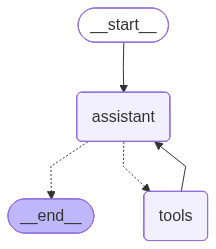

In [4]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# 系统提示词：限定助手的角色与任务，保证输出聚焦在算术计算
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# 定义“助手”节点：
# - 输入：MessagesState（包含当前对话消息列表）
# - 行为：将系统消息 + 历史消息传入大模型（已绑定工具），得到新的 AI 消息
# - 输出：追加一条 AI 消息到消息状态

def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"]) ]}

# 构建图（StateGraph）：声明状态类型为 MessagesState（内置消息归约器，按消息 ID 可覆盖/追加）
builder = StateGraph(MessagesState)

# 定义节点（工作单元）：
# - assistant：由大模型生成回复或工具调用
# - tools：当触发工具调用时，由 ToolNode 执行对应的 Python 函数
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# 定义边（控制流）：
# 1) 从 START 进入 assistant
builder.add_edge(START, "assistant")
# 2) 条件边：若 assistant 最新消息包含工具调用 -> 流转到 tools；否则 -> 流程结束
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
# 3) 工具执行后回到 assistant，让模型基于工具结果继续对话或结束
builder.add_edge("tools", "assistant")

# 启用内存检查点（MemorySaver）：用于记录每一步状态，以支持“时间旅行”（回放/分叉）
memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# 可视化图结构（xray=True 展示节点与条件流转），便于理解整体流程
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

像前面一样，我们来运行一次完整流程。

In [5]:
# 运行一次：将人类输入注入消息状态，并按节点顺序流式执行
# stream_mode="values" 表示每个节点执行后输出完整状态（便于学习/调试）

# 输入消息
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}

# 线程配置（thread_id 用于标识一次会话轨迹，支持时间旅行）
thread = {"configurable": {"thread_id": "1"}}

# 执行图：依次运行 assistant ->（若触发工具）tools -> assistant ... 直到结束
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_ZIldqqQdkoJoDQypKRmckpee)
 Call ID: call_ZIldqqQdkoJoDQypKRmckpee
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


## 浏览历史

给定 `thread_id`，我们可以使用 `get_state` 查看图的“当前”状态！

In [6]:
# 查看当前线程的最新状态快照（包含 values/next/config/metadata 等）
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='97257c29-124e-40a2-b198-5ae61ea6ee1c'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZIldqqQdkoJoDQypKRmckpee', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply', 'parameters': None}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 217, 'total_tokens': 235, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}, 'input_tokens': 0, 'output_tokens': 0, 'input_tokens_details': None}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-CEtiAMfKqLrgs1m9ZSK0AHCu4TU0o', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--f7bd24d5-0180-4c86-9b8f-6f0a3a3f08d5-0', tool_

我们也可以浏览代理的“状态历史”。

`get_state_history` 可以让我们获取先前每一步的状态记录。


In [7]:
# 获取线程的“状态历史”（从最近到最早）。用于回放与分叉。
all_states = [s for s in graph.get_state_history(thread)]

In [8]:
len(all_states)

5

列表的第一个元素就是当前状态，与 `get_state` 的结果一致。

In [9]:
all_states[-2]

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='97257c29-124e-40a2-b198-5ae61ea6ee1c')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08fb4f-554f-6b7e-8000-09e8dc422993'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-09-12T08:46:22.135772+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08fb4f-554c-6a37-bfff-c8c04e4a311a'}}, tasks=(PregelTask(id='3a3f79ec-49e1-a4d7-a661-951a7388e762', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZIldqqQdkoJoDQypKRmckpee', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply', 'parameters': None}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'p

上面的流程也可以如下图所示可视化：

![fig1.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038211b544898570be3_time-travel1.png)

## 回放（Replaying）

我们可以从任意一个历史步骤重新运行代理。

![fig2.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038a0bd34b541c78fb8_time-travel2.png)

我们回到“接收人类输入”的那一步来观察与回放。

In [10]:
to_replay = all_states[-2]

In [11]:
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='97257c29-124e-40a2-b198-5ae61ea6ee1c')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08fb4f-554f-6b7e-8000-09e8dc422993'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}}, created_at='2025-09-12T08:46:22.135772+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08fb4f-554c-6a37-bfff-c8c04e4a311a'}}, tasks=(PregelTask(id='3a3f79ec-49e1-a4d7-a661-951a7388e762', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZIldqqQdkoJoDQypKRmckpee', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply', 'parameters': None}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'p

查看该检查点的状态。

In [12]:
to_replay.values

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='97257c29-124e-40a2-b198-5ae61ea6ee1c')]}

我们还能看到接下来要调用的节点（`next`）。

In [13]:
to_replay.next

('assistant',)

我们也能拿到该检查点的 `config`，其中包含 `checkpoint_id` 与 `thread_id`。

In [14]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f08fb4f-554f-6b7e-8000-09e8dc422993'}}

要从这里回放，只需把该 `config` 传回给代理即可！

图会识别此检查点之前已执行过，因此会从该检查点开始“重放”其后的节点。

In [15]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_Hy82tnIEmh5osGubG9MpTPgl)
 Call ID: call_Hy82tnIEmh5osGubG9MpTPgl
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The result of multiplying 2 and 3 is 6.


现在，我们可以查看回放后当前线程的最新状态。

## 分叉（Forking）

如果我们想从同一个历史步骤“重新开始”，但换一个不同的输入，这就是“分叉”。

![fig3.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038f89f2d847ee5c336_time-travel3.png)

In [16]:
to_fork = all_states[-2]
to_fork.values["messages"]

[HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='97257c29-124e-40a2-b198-5ae61ea6ee1c')]

同样，我们也能拿到该步骤对应的 `config`。

In [17]:
to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f08fb4f-554f-6b7e-8000-09e8dc422993'}}

我们来在这个检查点上修改状态。

只需调用 `update_state` 并提供 `checkpoint_id`。

回顾 `messages` 归约器的规则：

- 默认是追加；除非显式提供“消息 ID”。
- 若提供相同“消息 ID”，则对该消息进行覆盖而不是追加。

因此要覆盖该条人类消息，只需提供其原始 `id`（可通过 `to_fork.values["messages"][0].id` 获取）。

In [18]:
fork_config = graph.update_state(
    to_fork.config,
    {"messages": [HumanMessage(content='Multiply 5 and 3',
                               id=to_fork.values["messages"][0].id)]},
)

In [19]:
fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f08fb52-c027-65c6-8001-488299027d7a'}}

这会创建一个新的“分叉”检查点。

注意：元数据（例如下一步将流转到哪个节点）会被保留！

当前线程的最新状态已被更新为分叉后的输入。

In [20]:
all_states = [state for state in graph.get_state_history(thread) ]
all_states[0].values["messages"]

[HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='97257c29-124e-40a2-b198-5ae61ea6ee1c')]

In [21]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='97257c29-124e-40a2-b198-5ae61ea6ee1c')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08fb52-c027-65c6-8001-488299027d7a'}}, metadata={'source': 'update', 'step': 1, 'parents': {}}, created_at='2025-09-12T08:47:53.869634+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f08fb4f-554f-6b7e-8000-09e8dc422993'}}, tasks=(PregelTask(id='39bf3845-e695-ad18-10ea-8c7792bbc4c2', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

接下来流式运行时，图会识别该检查点“尚未执行过后续节点”。

因此将“真正运行”后续节点，而不是简单回放。

In [22]:
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 5 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_AaFWfsqyIATWWOTf5CaNHOIN)
 Call ID: call_AaFWfsqyIATWWOTf5CaNHOIN
  Args:
    a: 5
    b: 3
================================= Tool Message =================================
Name: multiply

15
================================== Ai Message ==================================

The result of multiplying 5 and 3 is 15.


现在可以看到，当前状态已处于本次运行的终点。

In [23]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='97257c29-124e-40a2-b198-5ae61ea6ee1c'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_AaFWfsqyIATWWOTf5CaNHOIN', 'function': {'arguments': '{"a":5,"b":3}', 'name': 'multiply', 'parameters': None}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 217, 'total_tokens': 235, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}, 'input_tokens': 0, 'output_tokens': 0, 'input_tokens_details': None}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-CEtjsRHI8TlK4tFoIlkIlxCOXH1zG', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--7a66a26f-b871-4cde-8d20-6fb7937a2e7f-0', tool_

### 使用 LangGraph API 进行时间旅行

**⚠️ 说明**

自录制这些视频以来，Studio 已更新可本地运行并在浏览器中打开。现在推荐使用“本地开发服务器”来运行 Studio（而不是视频中展示的桌面应用）。请参考以下文档了解本地开发服务：
- 本地开发服务器概念：`https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server`
- 启动方法：`https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server`

在本模块的 `/studio` 目录下，执行如下命令启动本地开发服务器：

```
langgraph dev
```

启动后应看到类似输出：
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

在浏览器中打开 Studio UI：`https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`。

我们将通过 SDK 连接至该服务，并演示 LangGraph API 如何支持“时间旅行”（参考：`https://langchain-ai.github.io/langgraph/cloud/how-tos/human_in_the_loop_time_travel/#initial-invocation`）。

In [ ]:
if 'google.colab' in str(get_ipython()):
    raise Exception("Unfortunately LangGraph Studio is currently not supported on Google Colab")

In [ ]:
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")

#### 回放（Re-playing）

我们以 `updates` 模式流式查看：每个节点执行后，仅输出该节点对状态的“增量变化”。

In [ ]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id = "agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_SG7XYqDENGq7mwXrnioNLosS', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'type': 'ai', 'name': None, 'id': 'run-2c120fc3-3c82-4599-b8ec-24fbee207cad', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_SG7XYqDENGq7mwXrnioNLosS', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': None}
--------------------Tools Node--------------------
{'content': '6', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': '3b40d091-58b2-4566-a84c-60af67206307', 'tool_call_id': 'call_SG7XYqDENGq7mwXrnioNLosS', 'artifact': None, 'status': 'success'}
--------------------Assistant Node--------------------
{'content': 

现在，从指定的检查点进行“回放”。

做法：将该步骤的 `checkpoint_id` 传入运行接口。

In [ ]:
states = await client.threads.get_history(thread['thread_id'])
to_replay = states[-2]
to_replay

{'values': {'messages': [{'content': 'Multiply 2 and 3',
    'additional_kwargs': {'example': False,
     'additional_kwargs': {},
     'response_metadata': {}},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': 'df98147a-cb3d-4f1a-b7f7-1545c4b6f042',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': 'e497456f-827a-5027-87bd-b0ccd54aa89a',
   'name': 'assistant',
   'error': None,
   'interrupts': [],
   'state': None}],
 'metadata': {'step': 0,
  'run_id': '1ef6a449-7fbc-6c90-8754-4e6b1b582790',
  'source': 'loop',
  'writes': None,
  'parents': {},
  'user_id': '',
  'graph_id': 'agent',
  'thread_id': '708e1d8f-f7c8-4093-9bb4-999c4237cb4a',
  'created_by': 'system',
  'assistant_id': 'fe096781-5601-53d2-b2f6-0d3403f7e9ca'},
 'created_at': '2024-09-03T22:33:51.380352+00:00',
 'checkpoint_id': '1ef6a449-817f-6b55-8000-07c18fbdf7c8',
 'parent_checkpoint_id': '1ef6a449-816c-6fd6-bfff-32a56dd2635f'}

使用 `stream_mode="values"`，在回放中查看每个节点后的“完整状态”。

In [ ]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="values",
    checkpoint_id=to_replay['checkpoint_id']
):
    print(f"Receiving new event of type: {chunk.event}...")
    print(chunk.data)
    print("\n\n")

Receiving new event of type: metadata...
{'run_id': '1ef6a44a-5806-6bb1-b2ee-92ecfda7f67d'}



Receiving new event of type: values...
{'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'df98147a-cb3d-4f1a-b7f7-1545c4b6f042', 'example': False}]}



Receiving new event of type: values...
{'messages': [{'content': 'Multiply 2 and 3', 'additional_kwargs': {'example': False, 'additional_kwargs': {}, 'response_metadata': {}}, 'response_metadata': {}, 'type': 'human', 'name': None, 'id': 'df98147a-cb3d-4f1a-b7f7-1545c4b6f042', 'example': False}, {'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_Rn9YQ6iZyYtzrELBz7EfQcs0', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_1

也可以仅查看“增量更新（updates）”：只显示回放过程中各节点对状态做出的新增/修改内容。

In [ ]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=to_replay['checkpoint_id']
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_I2qudhMCwcw1GzcFN5q80rjj', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'type': 'ai', 'name': None, 'id': 'run-550e75ad-dbbc-4e55-9f00-aa896228914c', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_I2qudhMCwcw1GzcFN5q80rjj', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': None}
--------------------Tools Node--------------------
{'content': '6', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': '731b7d4f-780d-4a8b-aec9-0d8b9c58c40a', 'tool_call_id': 'call_I2qudhMCwcw1GzcFN5q80rjj', 'artifact': None, 'status': 'success'}
--------------------Assistant Node--------------------
{'content': 

#### 分叉（Forking）

接下来演示分叉：

- 先获取与上文相同的“人类输入”步骤。
- 然后为代理新建一个线程，用于在该检查点上分叉与继续运行。

In [ ]:
initial_input = {"messages": HumanMessage(content="Multiply 2 and 3")}
thread = await client.threads.create()
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=initial_input,
    stream_mode="updates",
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_HdWoyLELFZGEcqGxFt2fZzek', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'type': 'ai', 'name': None, 'id': 'run-cbd081b1-8cef-4ca8-9dd5-aceb134404dc', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_HdWoyLELFZGEcqGxFt2fZzek', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': None}
--------------------Tools Node--------------------
{'content': '6', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': '11dd4a7f-0b6b-44da-b9a4-65f1677c8813', 'tool_call_id': 'call_HdWoyLELFZGEcqGxFt2fZzek', 'artifact': None, 'status': 'success'}
--------------------Assistant Node--------------------
{'content': 

In [ ]:
states = await client.threads.get_history(thread['thread_id'])
to_fork = states[-2]
to_fork['values']

{'messages': [{'content': 'Multiply 2 and 3',
   'additional_kwargs': {'example': False,
    'additional_kwargs': {},
    'response_metadata': {}},
   'response_metadata': {},
   'type': 'human',
   'name': None,
   'id': '93c18b95-9050-4a52-99b8-9374e98ee5db',
   'example': False}]}

In [ ]:
to_fork['values']['messages'][0]['id']

'93c18b95-9050-4a52-99b8-9374e98ee5db'

In [ ]:
to_fork['next']

['assistant']

In [ ]:
to_fork['checkpoint_id']

'1ef6a44b-27ec-681c-8000-ff7e345aee7e'

现在来编辑状态。

再次回顾 `messages` 的归约规则：

- 默认追加；若提供相同“消息 ID”，则覆盖对应消息。
- 因此通过沿用原消息 `id`，可实现“把内容改为 3×3”。

In [ ]:
forked_input = {"messages": HumanMessage(content="Multiply 3 and 3",
                                         id=to_fork['values']['messages'][0]['id'])}

forked_config = await client.threads.update_state(
    thread["thread_id"],
    forked_input,
    checkpoint_id=to_fork['checkpoint_id']
)

In [ ]:
forked_config

{'configurable': {'thread_id': 'c99502e7-b0d7-473e-8295-1ad60e2b7ed2',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef6a44b-90dc-68c8-8001-0c36898e0f34'},
 'checkpoint_id': '1ef6a44b-90dc-68c8-8001-0c36898e0f34'}

In [ ]:
states = await client.threads.get_history(thread['thread_id'])
states[0]

{'values': {'messages': [{'content': 'Multiply 3 and 3',
    'additional_kwargs': {'additional_kwargs': {},
     'response_metadata': {},
     'example': False},
    'response_metadata': {},
    'type': 'human',
    'name': None,
    'id': '93c18b95-9050-4a52-99b8-9374e98ee5db',
    'example': False}]},
 'next': ['assistant'],
 'tasks': [{'id': 'da5d6548-62ca-5e69-ba70-f6179b2743bd',
   'name': 'assistant',
   'error': None,
   'interrupts': [],
   'state': None}],
 'metadata': {'step': 1,
  'source': 'update',
  'writes': {'__start__': {'messages': {'id': '93c18b95-9050-4a52-99b8-9374e98ee5db',
     'name': None,
     'type': 'human',
     'content': 'Multiply 3 and 3',
     'example': False,
     'additional_kwargs': {},
     'response_metadata': {}}}},
  'parents': {},
  'graph_id': 'agent'},
 'created_at': '2024-09-03T22:34:46.678333+00:00',
 'checkpoint_id': '1ef6a44b-90dc-68c8-8001-0c36898e0f34',
 'parent_checkpoint_id': '1ef6a44b-27ec-681c-8000-ff7e345aee7e'}

要从分叉处重新运行，只需传入该分叉返回的 `checkpoint_id`。

In [ ]:
async for chunk in client.runs.stream(
    thread["thread_id"],
    assistant_id="agent",
    input=None,
    stream_mode="updates",
    checkpoint_id=forked_config['checkpoint_id']
):
    if chunk.data:
        assisant_node = chunk.data.get('assistant', {}).get('messages', [])
        tool_node = chunk.data.get('tools', {}).get('messages', [])
        if assisant_node:
            print("-" * 20+"Assistant Node"+"-" * 20)
            print(assisant_node[-1])
        elif tool_node:
            print("-" * 20+"Tools Node"+"-" * 20)
            print(tool_node[-1])

--------------------Assistant Node--------------------
{'content': '', 'additional_kwargs': {'tool_calls': [{'index': 0, 'id': 'call_aodhCt5fWv33qVbO7Nsub9Q3', 'function': {'arguments': '{"a":3,"b":3}', 'name': 'multiply'}, 'type': 'function'}]}, 'response_metadata': {'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_157b3831f5'}, 'type': 'ai', 'name': None, 'id': 'run-e9759422-e537-4b9b-b583-36c688e13b4b', 'example': False, 'tool_calls': [{'name': 'multiply', 'args': {'a': 3, 'b': 3}, 'id': 'call_aodhCt5fWv33qVbO7Nsub9Q3', 'type': 'tool_call'}], 'invalid_tool_calls': [], 'usage_metadata': None}
--------------------Tools Node--------------------
{'content': '9', 'additional_kwargs': {}, 'response_metadata': {}, 'type': 'tool', 'name': 'multiply', 'id': '89787b0b-93de-4c0a-bea8-d2c3845534e1', 'tool_call_id': 'call_aodhCt5fWv33qVbO7Nsub9Q3', 'artifact': None, 'status': 'success'}
--------------------Assistant Node--------------------
{'content': 

### LangGraph Studio

我们也可以在 Studio UI 中观察分叉过程。本示例使用 `module-1/studio/langgraph.json` 指向的 `agent`（由 `module-1/studio/agent.py` 定义）。